In [191]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout

from collections import defaultdict

In [192]:
# Define target image size for CNN input
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3  # RGB images
BATCH_SIZE = 32
IMAGE_PATH = 'data/sorted'

In [193]:
train_dataset = tf.keras.utils.image_dataset_from_directory('data/sorted',
                                                   validation_split=0.2,
                                                   subset="training",
                                                   seed=123,
                                                   image_size=IMAGE_SIZE,
                                                   batch_size=BATCH_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory('data/sorted',
                                                   validation_split=0.2,
                                                   subset="validation",
                                                   seed=123,
                                                   image_size=IMAGE_SIZE,
                                                   batch_size=BATCH_SIZE)

Found 909 files belonging to 11 classes.
Using 728 files for training.
Found 909 files belonging to 11 classes.
Using 181 files for validation.


In [194]:
class_names = train_dataset.class_names

In [195]:
# Initialize a dictionary to hold counts
class_counts = defaultdict(int)

# Iterate over the training dataset
for images, labels in train_dataset:
    labels = labels.numpy()
    for label in labels:
        class_name = class_names[label]
        class_counts[class_name] += 1

# Print class counts
print("\nTraining set class counts:")
for class_name in class_names:
    count = class_counts.get(class_name, 0)
    print(f"{class_name}: {count}")



Training set class counts:
0: 58
1: 96
10: 82
2: 113
3: 17
4: 54
5: 43
6: 32
7: 30
8: 70
9: 133


2024-12-05 09:25:00.289537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


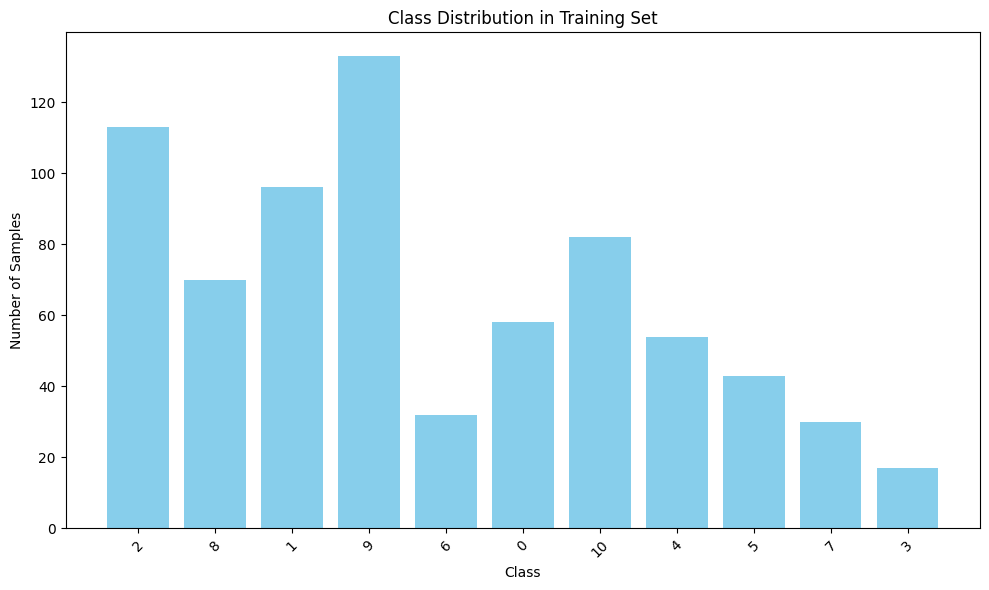

In [196]:
# Plot the class distribution
classes = list(class_counts.keys())
counts = [class_counts[class_name] for class_name in classes]

plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Set')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [197]:
# Initialize a dictionary to hold counts
val_class_counts = defaultdict(int)

# Iterate over the validation dataset
for images, labels in validation_dataset:
    labels = labels.numpy()
    for label in labels:
        class_name = class_names[label]
        val_class_counts[class_name] += 1

# Print class counts
print("\nValidation set class counts:")
for class_name in class_names:
    count = val_class_counts.get(class_name, 0)
    print(f"{class_name}: {count}")



Validation set class counts:
0: 17
1: 25
10: 16
2: 39
3: 3
4: 19
5: 10
6: 4
7: 9
8: 7
9: 32


2024-12-05 09:25:00.651422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


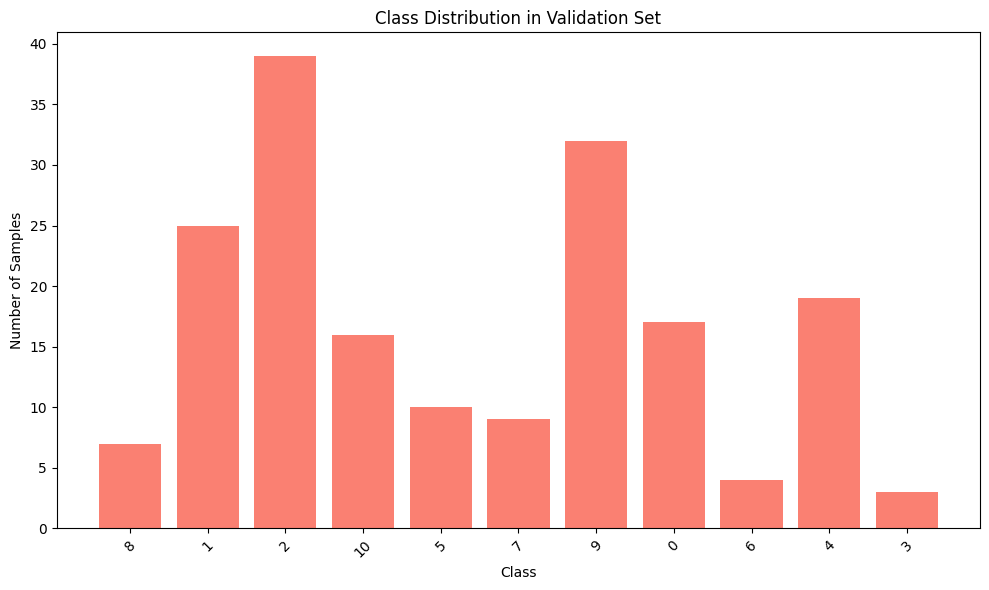

In [198]:
# Plot the class distribution
classes = list(val_class_counts.keys())
counts = [val_class_counts[class_name] for class_name in classes]

plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='salmon')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Validation Set')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [199]:
# Total number of samples in training and validation sets
num_train_samples = sum(class_counts.values())
num_val_samples = sum(val_class_counts.values())

print(f"\nTotal training samples: {num_train_samples}")
print(f"Total validation samples: {num_val_samples}")



Total training samples: 728
Total validation samples: 181


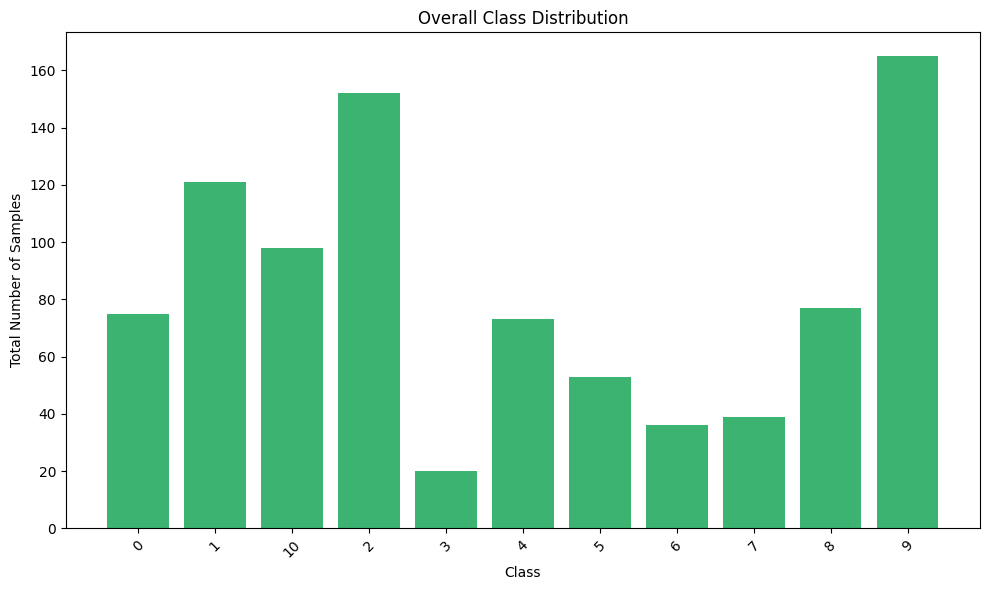

In [200]:
# Combine training and validation counts
total_class_counts = {class_name: class_counts.get(class_name, 0) + val_class_counts.get(class_name, 0) for class_name in class_names}

# Plot the overall class distribution
classes = list(total_class_counts.keys())
counts = [total_class_counts[class_name] for class_name in classes]

plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='mediumseagreen')
plt.xlabel('Class')
plt.ylabel('Total Number of Samples')
plt.title('Overall Class Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [201]:
# Calculate class weights
total_samples = num_train_samples
class_weights = {}

for i, class_name in enumerate(class_names):
    class_weights[i] = total_samples / (len(class_names) * class_counts[class_name])

print("\nClass weights:")
print(class_weights)


Class weights:
{0: 1.141065830721003, 1: 0.6893939393939394, 2: 0.8070953436807096, 3: 0.585679806918745, 4: 3.893048128342246, 5: 1.2255892255892256, 6: 1.5391120507399578, 7: 2.0681818181818183, 8: 2.206060606060606, 9: 0.9454545454545454, 10: 0.49760765550239233}


In [202]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [203]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [204]:
base_model = InceptionV3(
                    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3),
                    weights='imagenet',
                    include_top=False)

In [205]:
# Freeze the first 10 layers
for layer in base_model.layers[:10]:
    layer.trainable = False

x = base_model.output
x = tf.keras.layers.RandomFlip('horizontal', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))(x)
x = tf.keras.layers.RandomRotation(0.2)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(11, activation='softmax')(x)
model = Model(inputs=base_model.inputs, outputs=predictions)

In [206]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])

In [207]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

/usr/local/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2872']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 616ms/step - accuracy: 0.1133 - loss: 54.5251


In [208]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 52.15
initial accuracy: 0.21


In [209]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    class_weight=class_weights)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - accuracy: 0.0655 - loss: 2.4888 - val_accuracy: 0.1611 - val_loss: 2.5408
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy: 0.0808 - loss: 2.1202 - val_accuracy: 0.0403 - val_loss: 2.3203
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - accuracy: 0.0852 - loss: 1.4819 - val_accuracy: 0.1007 - val_loss: 2.3003
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - accuracy: 0.0948 - loss: 0.8107 - val_accuracy: 0.0671 - val_loss: 2.4871
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 103s 5s/step - accuracy: 0.0726 - loss: 0.3995 - val_accuracy: 0.0805 - val_loss: 2.5224
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.1079 - loss: 0.1613 - val_accuracy: 0.0872 - val_loss: 2.5450
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - accuracy: 0.0451 - loss: 0.0888 - val_accuracy: 0.1879 - val_loss: 2.5715
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy: 0.0783 - loss: 0.0451 - val_accuracy: 0.0805 - val_los

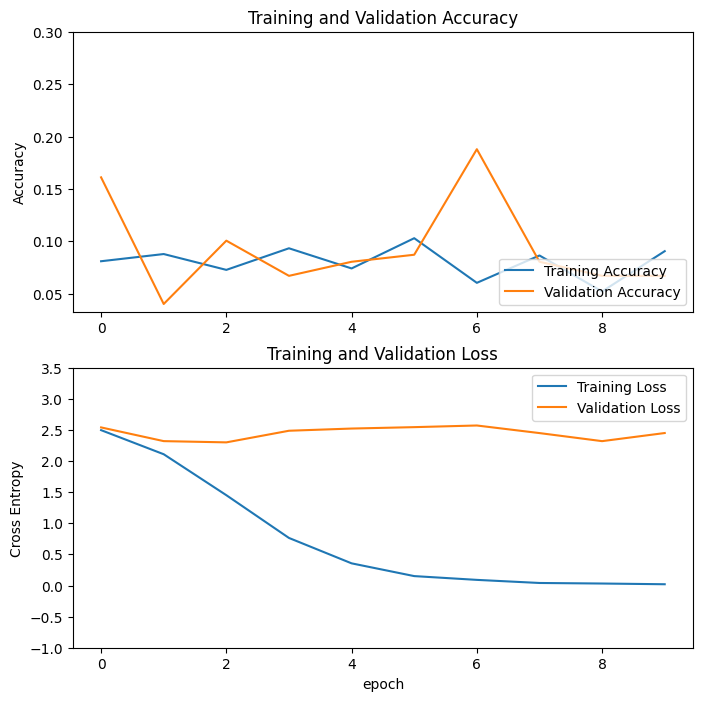

In [210]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),.3])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([-1,3.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [211]:
loss0, accuracy0 = model.evaluate(validation_dataset)
print("final loss: {:.2f}".format(loss0))
print("final accuracy: {:.2f}".format(accuracy0))

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 895ms/step - accuracy: 0.1459 - loss: 2.5401
final loss: 2.45
final accuracy: 0.13
